In [2]:
import h5py 
import numpy as np
import _mgard as mgard
import time

from tqdm import tqdm

In [3]:

class Slicer:

    # default 引数
    def __init__(self,filename="/scratch/aoyagir/step1_500_test.h5") -> None:
        self.filename = filename
        self.file = h5py.File(filename, 'r')
        self.dataset = self.file['data']
        print(self.dataset.shape)

    # Access specific elements in the concatenated array
    def access_array_element(self,timestep, x, y, z):
        element = self.dataset[timestep, x, y, z]
        return element

    # Access a subset of the concatenated array
    def slice_multiple_step(self, file, timestep_start, timestep_end, x_start, x_end, y_start, y_end, z_start, z_end):
        subset = self.dataset[timestep_start:timestep_end, x_start:x_end, y_start:y_end, z_start:z_end]
        return subset
    
    # slice siingle step
    def slice_single_step(self, timestep,  x_start, x_end, y_start, y_end, z_start, z_end):
        subset = self.dataset[timestep,  x_start:x_end, y_start:y_end, z_start:z_end]
        retsubset = np.squeeze(subset)
        return retsubset

    # slice sigle step by size
    def get_xyz_offset_by_size(self, size):
        # 100MB -> 「100/(sizeof(float))」個のデータ
        sizeFloat = 4 # byte
        return int((size/sizeFloat)**(1/3))



In [4]:
slicer = Slicer("/scratch/aoyagir/step1_256_test_0902.h5")

(257, 1024, 1024, 1024)


In [5]:
# create a file to write the results
import csv
from datetime import datetime

# Get the current date and time
current_time = datetime.now()

# Format the current date and time as a string
timestamp = current_time.strftime("%Y%m%d_%H%M%S")

# timestep to conduct the benchmark
timestep = 0


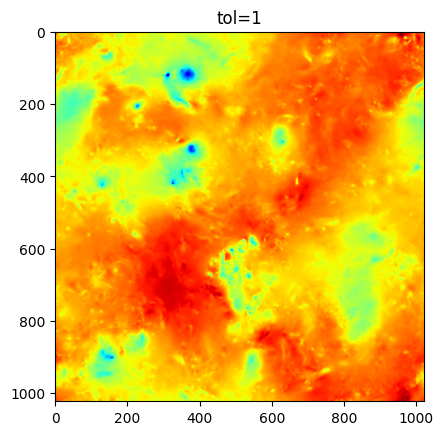

In [8]:
# Define the number of repetitions and initialize a list for results

import matplotlib.pyplot as plt

results = []
tols = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1, 0.5, 1]

configGPU = mgard.Config()
configGPU.dev_type = mgard.DeviceType.CUDA

OriginalSize = 4*1024*1024*1024

offset = slicer.get_xyz_offset_by_size(OriginalSize)

original = slicer.slice_single_step(timestep, 0, offset, 0, offset, 0, offset)

data = original[0,:,:]
plt.imshow(data, cmap='jet')
plt.title("original")
plt.savefig("./images_by_tol/original_timestep={}_size={}.png".format(timestep,OriginalSize))
# Wrap your outer loop with tqdm to create a progress bar

for tol in tols: # 100 iteration


    compressed = mgard.compress(original, tol, 0, mgard.ErrorBoundType.REL, configGPU)

    decompressed = mgard.decompress(compressed, configGPU)
    data = decompressed[0,:,:]
    plt.imshow(data, cmap='jet')
    plt.title("tol={}".format(tol))
    plt.savefig("./images_by_tol/size={}_tol={}_timestep={}.png".format(OriginalSize,tol,timestep))

# Convert the results list to a NumPy array for easier manipulation
results_array = np.array(results)